In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%set_env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [3]:
import sys
import cv2
import os
import math
import random
import pickle
import copy
import numpy as np
import pandas as pd
sys.path.append("C:\\Users\\user\\Documents\\Workspace\\MeronymNet-PyTorch\\src")

In [4]:
import torch
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import DataLoader
import torch.utils.data as data_utils
from torch.utils.tensorboard import SummaryWriter

In [5]:
from losses import BoxVAE_losses as loss
from evaluation import metrics
from utils import plot_utils
from utils import data_utils as data_loading
from losses import BoxVAE_losses as loss
from components.AutoEncoder import GCNAutoEncoder
from components.TwoStageAutoEncoder import TwoStageAutoEncoder

In [6]:
import matplotlib.pyplot as plt

In [7]:
batch_size = 128
batch_train_loader, batch_val_loader = data_loading.load_data(obj_data_postfix = '_obj_boundary',
                                                              part_data_post_fix = '_scaled',
                                                              file_postfix = '_combined',
                                                              seed=345,
                                                              batch_size=batch_size)

C:\Users\user\miniconda3\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [8]:
import gc
gc.collect()

21

In [18]:
def load_model(model_class, model_settings, model_path, is_base=False):
    
    latent_dims = model_settings['latent_dims']
    batch_size = model_settings['batch_size']
    num_nodes = model_settings['num_nodes']
    bbx_size = model_settings['bbx_size']
    num_classes = model_settings['num_classes']
    label_shape = model_settings['label_shape']
    batch_size = model_settings['batch_size']
    learning_rate = model_settings['learning_rate']
    hidden1 = model_settings['hidden1']
    hidden2 = model_settings['hidden2']
    hidden3 = model_settings['hidden3']
    dense_hidden1=16
    dense_hidden2=32
    adaptive_margin = model_settings['adaptive_margin']
    output_log = False
    area_encoding = False
    variational=False
    coupling=True
    obj_bbx_conditioning=True
    if is_base:
        vae = model_class(latent_dims,num_nodes,bbx_size,num_classes,label_shape,hidden1, hidden2, hidden3,
                          dynamic_margin=adaptive_margin,
                         predict_edges=True,
                         predict_class=True,)
        vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))
        return vae
    
    vae = model_class(latent_dims,
                      num_nodes,
                      bbx_size,
                      num_classes,
                      label_shape,
                      hidden1,
                      hidden2,
                      hidden3,
                      dense_hidden1,
                      dense_hidden2,
                      adaptive_margin,
                      output_log,
                      area_encoding,
                      coupling,
                      obj_bbx_conditioning
                    )
    vae.load_state_dict(torch.load(model_path+ '/model_weights.pth'))
    return vae


In [48]:
def generate_objects(batch_loader, model, num_nodes, num_classes, is_base=False):
    
    class_dict = {0:'cow', 1:'sheep', 2:'bird', 3:'person', 4:'cat', 5:'dog', 6:'horse'}
    res_dfs = []
    node_true_arrs = []
    node_pred_arrs = []

    for i, val_data in enumerate(batch_loader, 0):
        val_data.cuda()
        node_data_true = val_data.x
        label_true = node_data_true[:,:1]
        y_true = val_data.y
        class_true = y_true[:, :num_classes]
        X_obj_true = y_true[:, num_classes:]
        adj_true = val_data.edge_index
        class_true  = torch.flatten(class_true)
        batch_size  = len(node_data_true)//num_nodes
        
        if is_base:
            
            obj_true = torch.repeat_interleave(torch.unsqueeze(X_obj_true,-2),num_nodes, -2)
            node_true = node_data_true[:, 1:]
            node_true = torch.reshape(node_true, [batch_size, num_nodes, 4])
            node_data_true[:, 1:] = torch.reshape(metrics.obj_scaling(node_true, obj_true),
                                              (batch_size*num_nodes, 4))
            output = model(adj_true, node_data_true, label_true , class_true, predict_adj_class=True)
            node_data_pred_test = output[0]
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, None, node_data_pred_test,
                                                                           None,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           False,
                                                                           True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        else:
            output = model(adj_true, node_data_true, X_obj_true, label_true , class_true, False)
            node_data_pred_test = output[0]
            X_obj_pred_test = output[1]
#             X_obj_pred = torch.cat(((torch.tensor([1.0]).cuda()-X_obj_pred)*torch.tensor([0.5]).cuda(),
#                                 (torch.tensor([1.0]).cuda()+X_obj_pred)*torch.tensor([0.5]).cuda()),
#                               -1)
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, X_obj_true, node_data_pred_test,
                                                                           X_obj_pred_test,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           True, True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        
        node_true_arrs.append(node_true)
        node_pred_arrs.append(node_pred*label_vals)
        res_dfs.append(generated_metrics)
        
    node_true_arr = np.concatenate(node_true_arrs)
    
    node_pred_arr = np.concatenate(node_pred_arrs)
    
    result = pd.concat(res_dfs)
    result['obj_class'] = np.where(result['obj_class'].isna(), 0, result['obj_class'])
    result['obj_class'] = result['obj_class'].astype('int')
    result['obj_class'].replace(class_dict, inplace=True)
    result.where(result['part_labels']!=0, np.NaN, inplace=True)
    result['part_labels'] = np.where(result['part_labels'].isna(), 0, result['part_labels'])
    result['part_labels'] = result['part_labels'].astype('int')
    result['id'] = np.repeat(np.array(list(range(int(len(result)/num_nodes)))), 16)
        
    return node_true_arr, node_pred_arr, result
    
    
    

In [90]:
def inference(X_obj, part_decoder, gmm, obj_class, nodes, batch_size, latent_dims):
    
    nodes = torch.reshape(nodes,(batch_size,part_decoder.num_nodes))
    obj_class = torch.reshape(obj_class, 
                              (batch_size, num_classes))
    
    # obj sampling
    z_latent_obj = torch.tensor(gmm.sample(batch_size)[0]).cuda().float()
    z_latent_obj = torch.cat(((torch.tensor([1.0]).cuda()-z_latent_obj)*torch.tensor([0.5]).cuda(),
                                (torch.tensor([1.0]).cuda()+z_latent_obj)*torch.tensor([0.5]).cuda()),
                              -1)
    
    print(z_latent_obj.shape, obj_class.shape)
    conditioned_obj_latent = torch.cat([obj_class, z_latent_obj],dim=-1)
    conditioned_obj_latent = torch.cat([nodes, conditioned_obj_latent],dim=-1)

    # part sampling
    z_latent_part = torch.normal(torch.zeros([batch_size,latent_dims])).cuda()
    conditioned_part_latent = torch.cat([conditioned_obj_latent, z_latent_part],dim=-1)
    
    x_bbx, _, _, _ = part_decoder(conditioned_part_latent)
    
    return x_bbx, z_latent_obj
    
def generate_variation_objects(batch_loader, model, gmm, num_nodes, num_classes, is_base=False):
    
    class_dict = {0:'cow', 1:'sheep', 2:'bird', 3:'person', 4:'cat', 5:'dog', 6:'horse'}
    res_dfs = []
    node_true_arrs = []
    node_pred_arrs = []
    part_decoder = model.gcn_decoder
    latent_dims = 64
    for i, val_data in enumerate(batch_loader, 0):
        val_data.cuda()
        node_data_true = val_data.x
        label_true = node_data_true[:,:1]
        y_true = val_data.y
        class_true = y_true[:, :num_classes]
        X_obj_true = y_true[:, num_classes:]
        adj_true = val_data.edge_index
        class_true  = torch.flatten(class_true)
        batch_size  = len(node_data_true)//num_nodes
        
        if is_base:
            
            obj_true = torch.repeat_interleave(torch.unsqueeze(X_obj_true,-2),num_nodes, -2)
            node_true = node_data_true[:, 1:]
            node_true = torch.reshape(node_true, [batch_size, num_nodes, 4])
            node_data_true[:, 1:] = torch.reshape(metrics.obj_scaling(node_true, obj_true),
                                              (batch_size*num_nodes, 4))
            output = inference(X_obj_true, part_decoder, gmm, class_true, label_true, batch_size, latent_dims)
            node_data_pred_test = output[0]
            X_obj_pred_test = output[1]
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, None, node_data_pred_test,
                                                                           None,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           False,
                                                                           True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        else:
            output = inference(X_obj_true, part_decoder, gmm, class_true, label_true, batch_size, latent_dims)
            node_data_pred_test = output[0]
            X_obj_pred_test = output[1]
            node_true, node_pred, generated_metrics = metrics.get_metrics(node_data_true, X_obj_true, node_data_pred_test,
                                                                           X_obj_pred_test,
                                                                           label_true,
                                                                           class_true,
                                                                           num_nodes,
                                                                           num_classes,
                                                                           True, True)
            label_vals = np.reshape(label_true.detach().to("cpu").numpy(), (node_data_pred_test.shape[0],
                                                                            node_data_pred_test.shape[1],1))
        
        
        node_true_arrs.append(node_true)
        node_pred_arrs.append(node_pred*label_vals)
        res_dfs.append(generated_metrics)
        
    node_true_arr = np.concatenate(node_true_arrs)
    
    node_pred_arr = np.concatenate(node_pred_arrs)
    
    result = pd.concat(res_dfs)
    result['obj_class'] = np.where(result['obj_class'].isna(), 0, result['obj_class'])
    result['obj_class'] = result['obj_class'].astype('int')
    result['obj_class'].replace(class_dict, inplace=True)
    result.where(result['part_labels']!=0, np.NaN, inplace=True)
    result['part_labels'] = np.where(result['part_labels'].isna(), 0, result['part_labels'])
    result['part_labels'] = result['part_labels'].astype('int')
    result['id'] = np.repeat(np.array(list(range(int(len(result)/num_nodes)))), 16)
        
    return node_true_arr, node_pred_arr, result

In [40]:
model_paths = [
    'D:/meronym_data/model/two_stage_small_obj_conditioning/Obj-Box-4.8e-05-batch-128-h1-32-h2-16-h3-128-test'
#     'D:/meronym_data/model/adaptive_margin_softmax_margin_loss/GCN-lr-8.5e-05-batch-128-h1-32-h2-16-h3-128-test',
#     'D:/meronym_data/model/two_stage_variational_obj_parts_conditioning/Obj-Box-5.5e-05-batch-128-h1-32-h2-16-h3-128-test',
#     'D:/meronym_data/model/two_stage_weighted_IOU_no_obj_mse_weighted_obj/Obj-Box-5e-05-batch-128-h1-32-h2-16-h3-128-test',   
#     'D:/meronym_data/model/two_stage_gated_adjacency/Obj-Box-5.6e-05-batch-128-h1-32-h2-16-h3-128-test',
]
model_settings =[
    
     {
        "batch_size": 128,
        "latent_dims": 64,
        "num_nodes": 16,
        "bbx_size": 4,
        "num_classes": 7,
        "label_shape": 1,
        "learning_rate": 0.000048,
        "hidden1": 32,
        "hidden2": 16,
        "hidden3": 128,
        "adaptive_margin":True,
        "is_base": False
    }, 
#     {
#         "batch_size": 128,
#         "latent_dims": 64,
#         "num_nodes": 16,
#         "bbx_size": 4,
#         "num_classes": 7,
#         "label_shape": 1,
#         "learning_rate": 0.000085,
#         "hidden1": 32,
#         "hidden2": 16,
#         "hidden3": 128,
#         "adaptive_margin":True,
#         "is_base": True
#     },
#     {
#         "batch_size": 128,
#         "latent_dims": 64,
#         "num_nodes": 16,
#         "bbx_size": 4,
#         "num_classes": 7,
#         "label_shape": 1,
#         "learning_rate": 0.000055,
#         "hidden1": 32,
#         "hidden2": 16,
#         "hidden3": 128,
#         "adaptive_margin":True,
#         "is_base": False
#     },
#     {
#         "batch_size": 128,
#         "latent_dims": 64,
#         "num_nodes": 16,
#         "bbx_size": 4,
#         "num_classes": 7,
#         "label_shape": 1,
#         "learning_rate": 0.00005,
#         "hidden1": 32,
#         "hidden2": 16,
#         "hidden3": 128,
#         "adaptive_margin":True,
#         "is_base": False
#     },
#     {
#         "batch_size": 128,
#         "latent_dims": 64,
#         "num_nodes": 16,
#         "bbx_size": 4,
#         "num_classes": 7,
#         "label_shape": 1,
#         "learning_rate": 0.000056,
#         "hidden1": 32,
#         "hidden2": 16,
#         "hidden3": 128,
#         "adaptive_margin":True,
#         "is_base": False
#     }
]
model_classes = [TwoStageAutoEncoder]
labels = ['Original', 'Base', 'Obj Box Conditioned'] #'Margin loss','Two Stage', 'IOU loss fixed', 'Gated Adjacency'
base_model_path ='D:/meronym_data/model/base_model/GCN-lr-8e-05-batch-128-h1-32-h2-16-h3-128-test'
base_model_setting = {
    "latent_dims": 64,
    "batch_size": 128,
    "num_nodes": 16,
    "bbx_size": 4,
    "num_classes": 7,
    "label_shape": 1,
    "learning_rate": 0.00008,
    "hidden1": 32,
    "hidden2": 16,
    "hidden3": 128,
    "adaptive_margin":False,
}
summary_path = 'D:/meronym_data/runs/generation_comparison'

In [91]:
#testing loop
import gc
gc.collect()
num_classes = 7
num_nodes = 16

base_model = load_model(GCNAutoEncoder, base_model_setting, base_model_path, is_base=True)
base_node_true, base_node_pred, reconstructions_metrics =  generate_objects(batch_val_loader, base_model,
                                                                            num_nodes, num_classes, True)

# generated_object_arrs = [base_node_true, base_node_pred]
gen_obj_arrs = [base_node_true, base_node_pred]

for settings, path, model_class in zip(model_settings, model_paths, model_classes):

    is_base = settings['is_base']
    model = load_model(model_class, settings, path, is_base=is_base)
    node_true, node_pred, reconstructions_metrics =  generate_variation_objects(batch_val_loader, model, gmm,
                                                                            num_nodes, num_classes, is_base)
    gen_obj_arrs.append(node_pred)
    


torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([128, 7])
torch.Size([128, 4]) torch.Size([1

In [92]:
gen_obj_arrs[1].shape

(6720, 16, 4)

(3,)


TypeError: 'AxesSubplot' object is not subscriptable

<Figure size 432x288 with 0 Axes>

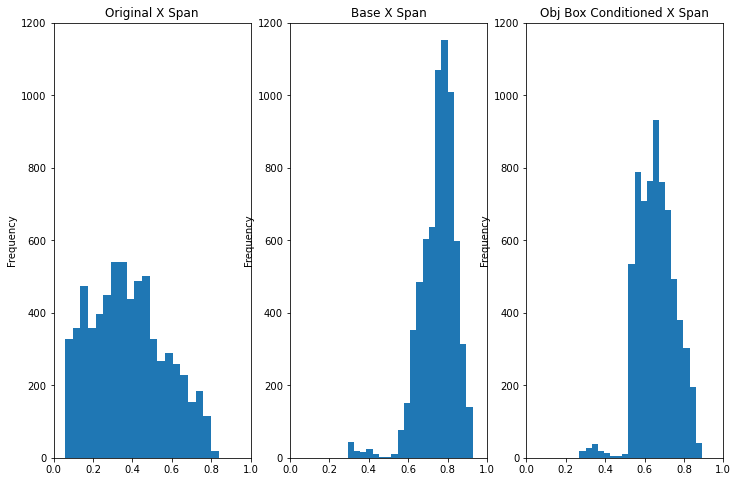

<Figure size 432x288 with 0 Axes>

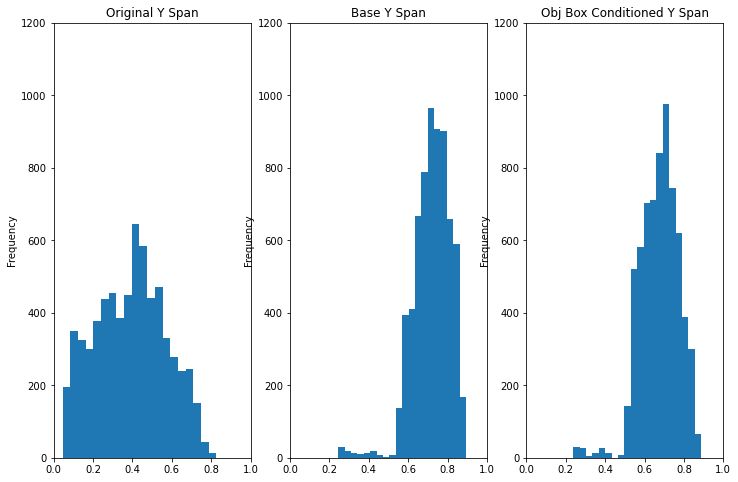

<Figure size 432x288 with 0 Axes>

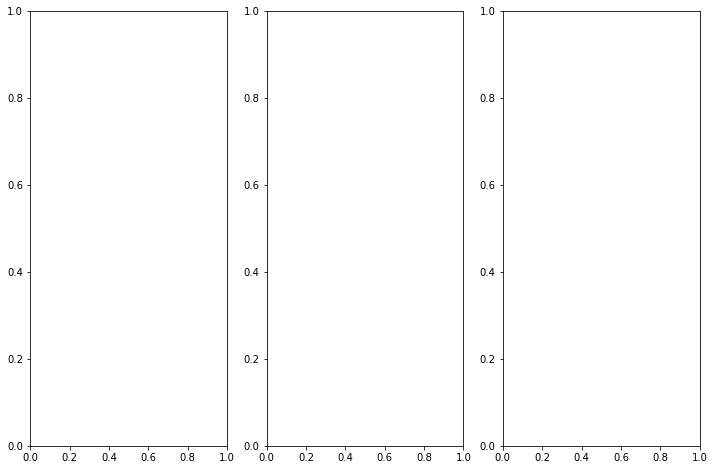

In [35]:
num_panels = len(gen_obj_arrs)


y = min(3, num_panels)
x = max(num_panels//3, 1)

plt.figure()
f, arr = plt.subplots(x, y)
f.set_size_inches(12, 8)
print(arr.shape)
for j in range(num_panels):
    x_min = np.min(gen_obj_arrs[j][:, :, 0], axis=1)
    x_max = np.max(gen_obj_arrs[j][:, :, 2], axis=1)

    x_span = x_max-x_min
    
    if len(arr.shape)>1:
        arr[j//3][j%3].hist(x_span, bins=20)
        arr[j//3][j%3].set(title=labels[j]+' X Span', ylabel='Frequency')
        arr[j//3][j%3].axis(xmin=0., xmax = 1.)
        arr[j//3][j%3].axis(ymin=0, ymax = 1200)
    else:
        arr[j%3].hist(x_span, bins=20)
        arr[j%3].set(title=labels[j]+' X Span', ylabel='Frequency')
        arr[j%3].axis(xmin=0., xmax = 1.)
        arr[j%3].axis(ymin=0, ymax = 1200)

plt.figure()
f, arr = plt.subplots(x, y)
f.set_size_inches(12, 8)

for j in range(num_panels):
    y_min = np.min(gen_obj_arrs[j][:, :, 1], axis=1)
    y_max = np.max(gen_obj_arrs[j][:, :, 3], axis=1)

    y_span = y_max-y_min
    
    if len(arr.shape)>1:
        arr[j//3][j%3].hist(y_span, bins=20)
        arr[j//3][j%3].set(title=labels[j]+' Y Span', ylabel='Frequency')
        arr[j//3][j%3].axis(xmin=0., xmax = 1.)
        arr[j//3][j%3].axis(ymin=0, ymax = 1200)
    
    else:
        arr[j%3].hist(y_span, bins=20)
        arr[j%3].set(title=labels[j]+' Y Span', ylabel='Frequency')
        arr[j%3].axis(xmin=0., xmax = 1.)
        arr[j%3].axis(ymin=0, ymax = 1200)
    
plt.figure()
f, arr = plt.subplots(x, y)
f.set_size_inches(12, 8)

for j in range(num_panels):
    
    x_min = np.min(gen_obj_arrs[j][:, :, 0], axis=1)
    y_min = np.min(gen_obj_arrs[j][:, :, 1], axis=1)
    x_max = np.max(gen_obj_arrs[j][:, :, 2], axis=1)
    y_max = np.max(gen_obj_arrs[j][:, :, 3], axis=1)

    x_span = x_max-x_min
    y_span = y_max-y_min

    scale = x_span/y_span
    
    arr[j//3][j%3].hist(scale, bins=20)
    arr[j//3][j%3].set(title=labels[j]+' Scale Frequency', ylabel='Frequency')
    arr[j//3][j%3].axis(xmin=0., xmax = 1.5)
    arr[j//3][j%3].axis(ymin=0, ymax = 1200)




1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 3
1 3 

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

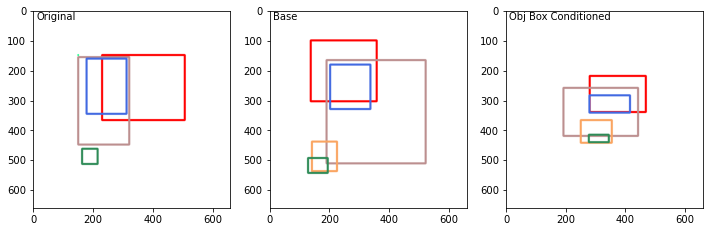

In [94]:

num_objects = len(gen_obj_arrs[0])
num_panels = len(gen_obj_arrs)
class_dict = {0:'cow', 1:'sheep', 2:'bird', 3:'person', 4:'cat', 5:'dog', 6:'horse'}

if not os.path.isdir(summary_path):
    os.mkdir(summary_path)

for obj_class in class_dict.values():
    if not os.path.isdir(summary_path+"/"+obj_class):
        os.mkdir(summary_path+"/"+obj_class)

# for label, obj_arr in zip(labels, gen_obj_arrs):
for i in range(num_objects):
    y = min(3, num_panels)
    x = max(num_panels//3, 1)
    print(x, y, num_panels)
    plt.figure()
    f, arr = plt.subplots(x, y)
    f.set_size_inches(12, 8)

    for j in range(num_panels):
        
        if len(arr.shape)>1:
            arr[j//3][j%3].imshow(plot_utils.plot_bbx(gen_obj_arrs[j][i]))
            arr[j//3][j%3].text(10, 30, labels[j])
            
        else:
            arr[j%3].imshow(plot_utils.plot_bbx(gen_obj_arrs[j][i]))
            arr[j%3].text(10, 30, labels[j])

    obj_class = reconstructions_metrics[(reconstructions_metrics['id']==i) 
                    & ~(reconstructions_metrics['obj_class'].isna())]['obj_class'].unique()[0]
    plt.savefig(summary_path+"/"+obj_class+"/"+str(i)+'-comp.png')
    plt.close('all')
    


In [73]:

from sklearn import mixture



In [95]:
gmmx_arr = []
y_arr = []

for i, val_data in enumerate(batch_train_loader, 0):
    
    node_data_true = val_data.x
    label_true = node_data_true[:,:1]
    y_true = val_data.y
    class_true = y_true[:, :num_classes]
    X_obj_true = y_true[:, num_classes:]
    
    x_arr.append(X_obj_true.to('cpu').numpy())
    y_arr.append(np.argmax(class_true.to('cpu').numpy(),axis=-1))
    
X = np.concatenate(x_arr)
y = np.concatenate(y_arr)
X = X[:,2:]-X[:,:2]
    

#Compute the means of the individual classes
# n_classes = len(np.unique(y))
# means = np.zeros((n_classes,204))
# weights = np.ones(n_classes) * (X.shape[0]/float(n_classes))/X.shape[0]
# inv_cov = np.zeros((n_classes,204,204))
# for j in range(7):
#     means[j,] = np.mean(X[y == j])
#     inv_cov[j,:,:] = np.linalg.inv(np.cov(X[y == j]))

gmm = mixture.GaussianMixture(n_components=10, covariance_type="full").fit(X)

In [97]:
from sklearn.model_selection import GridSearchCV


def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(5, 10),
    "covariance_type": ["spherical", "diag", "full"],
}
grid_search = GridSearchCV(
    mixture.GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)


df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
14,9,full,-51263.967388
13,8,full,-51184.558716
12,7,full,-51072.247721
11,6,full,-50790.645132
9,9,diag,-50641.764061
